In [1]:
import pickle, os
import numpy as np
import scvelo as scv
import scanpy
import torch

from veloproj import *

scv.settings.verbosity = 1


In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/cqiao/Melania/adata_human_def.h5',
                               '--model-name', 'Melania_Erythroid_human_model.cpt',
                               '--exp-name', 'CohAE_Melania_Erythroid_human',
                               '--device', 'cuda:3',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', "SU",
                               '--ld_nb_g_src', "X",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'type2',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir='/data/groups/yhhuang/cqiao/Melania/adata_human_def.h5', device='cuda:3', exp_name='CohAE_Melania_Erythroid_human', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=1.0, h_dim=256, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='X', log_interval=100, lr=1e-05, lr_decay=0.9, mask_cluster_list=None, model_name='Melania_Erythroid_human_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='SU', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='type2', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("Early Erythroid", "Mid  Erythroid"), ('Mid  Erythroid', "Late Erythroid")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
par_path = "/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/notebooks/Melania_human/"
fast_data_path = "data.h5ad"
if fast_data_path in os.listdir(par_path):
    adata = scanpy.read_h5ad(os.path.join(par_path, fast_data_path))
else:
    adata = scanpy.read_h5ad(args.data_dir)
    sel = np.zeros(adata.n_obs, dtype=np.bool)
    sel = sel | (adata.obs.celltype == "Erythroid1").values | (adata.obs.celltype == "Erythroid2").values | (adata.obs.celltype == "Erythroid3").values
    sel = sel | (adata.obs.celltype == "Blood progenitors 1").values | sel | (adata.obs.celltype == "Blood progenitors 2").values
    adata = adata[sel]
    scv.utils.show_proportions(adata)
    scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
    scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
    scv.tl.velocity_confidence(adata, vkey='stc_velocity')

print(adata)



AnnData object with n_obs × n_vars = 35877 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'type', 'samp', 'leiden', 'type2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'leiden', 'neighbors', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'stc_velocity_params', 'type2_colors'
    obsm: 'X_pca', 'X_umap', 'stc_velocity_umap'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'stc_velocity', 'unspliced', 'variance_stc_velocity'
    obsp: 'connectivities', 'distances'


saving figure to file ./figures/scvelo_Melania_Erythroid_human_stochastical.png


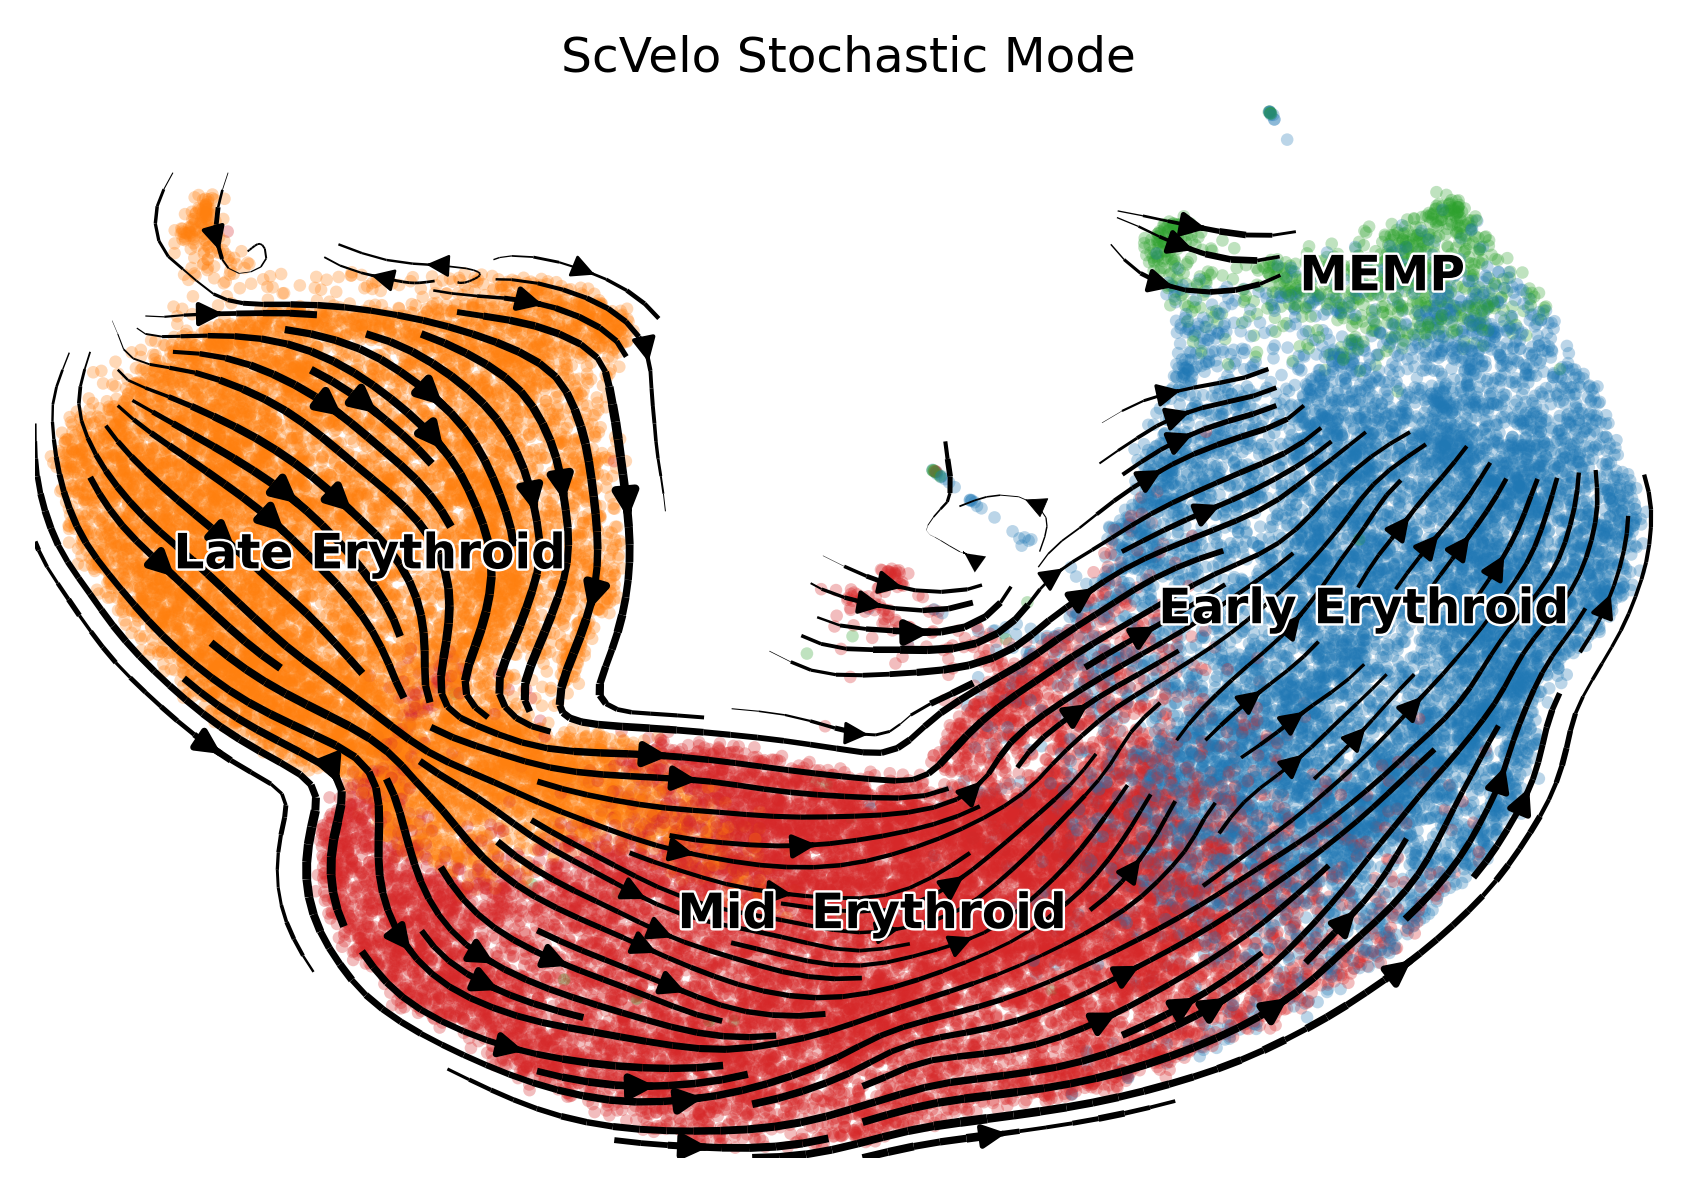

# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.081447646, ('Mid  Erythroid', 'Late Erythroid'): 0.04631139}
Total Mean: 0.06387951970100403
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.7524644, ('Mid  Erythroid', 'Late Erythroid'): 0.891103}
Total Mean: 0.821783721446991
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.3915759926120027, ('Mid  Erythroid', 'Late Erythroid'): -0.6590774334932159}
Total Mean: -0.5253267130526094
# In-cluster Coherence
{'Early Erythroid': 0.84404796, 'Late Erythroid': 0.9330105, 'MEMP': 0.9422879, 'Mid  Erythroid': 0.8535601}
Total Mean: 0.8932266235351562
# In-cluster Confidence
{'Early Erythroid': 0.8211951176751143, 'Late Erythroid': 0.9371989427152257, 'MEMP': 0.9497227164934267, 'Mid  Erythroid': 0.8122398725342098}
Total Mean: 0.8800891623544941


In [7]:
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col, dpi=350,
                                title='ScVelo Stochastic Mode', save="Melania_Erythroid_human_stochastical.png")
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity", x_emb=args.vis_key)

Train Epoch: 100/20000 	Loss: 5715.382324
Train Epoch: 200/20000 	Loss: 5652.771973
Train Epoch: 300/20000 	Loss: 5595.839355
Train Epoch: 400/20000 	Loss: 5574.847168
Train Epoch: 500/20000 	Loss: 5556.968750
Train Epoch: 600/20000 	Loss: 5552.323242
Train Epoch: 700/20000 	Loss: 5549.895020
Train Epoch: 800/20000 	Loss: 5548.622559
Train Epoch: 900/20000 	Loss: 5547.893555
Train Epoch: 1000/20000 	Loss: 5547.234863
Train Epoch: 1100/20000 	Loss: 5546.574219
Train Epoch: 1200/20000 	Loss: 5536.529297
Train Epoch: 1300/20000 	Loss: 5638.722656
Train Epoch: 1400/20000 	Loss: 5510.136230
Train Epoch: 1500/20000 	Loss: 5699.739258
Train Epoch: 1600/20000 	Loss: 5669.563477
Train Epoch: 1700/20000 	Loss: 5688.193848
Train Epoch: 1800/20000 	Loss: 5508.108398
Train Epoch: 1900/20000 	Loss: 5708.910645
Train Epoch: 2000/20000 	Loss: 5677.021973
Train Epoch: 2100/20000 	Loss: 5706.564453
Train Epoch: 2200/20000 	Loss: 5687.793945
Train Epoch: 2300/20000 	Loss: 5707.662109
Train Epoch: 2400/20

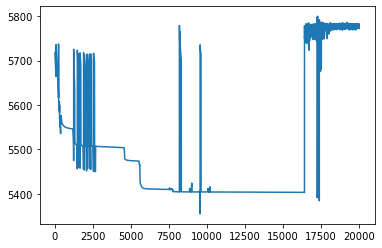

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
or disable the progress bar using `show_progress_bar=False`.
saving figure to file ./figures/scvelo_Melania_Erythroid_human_pojection.png


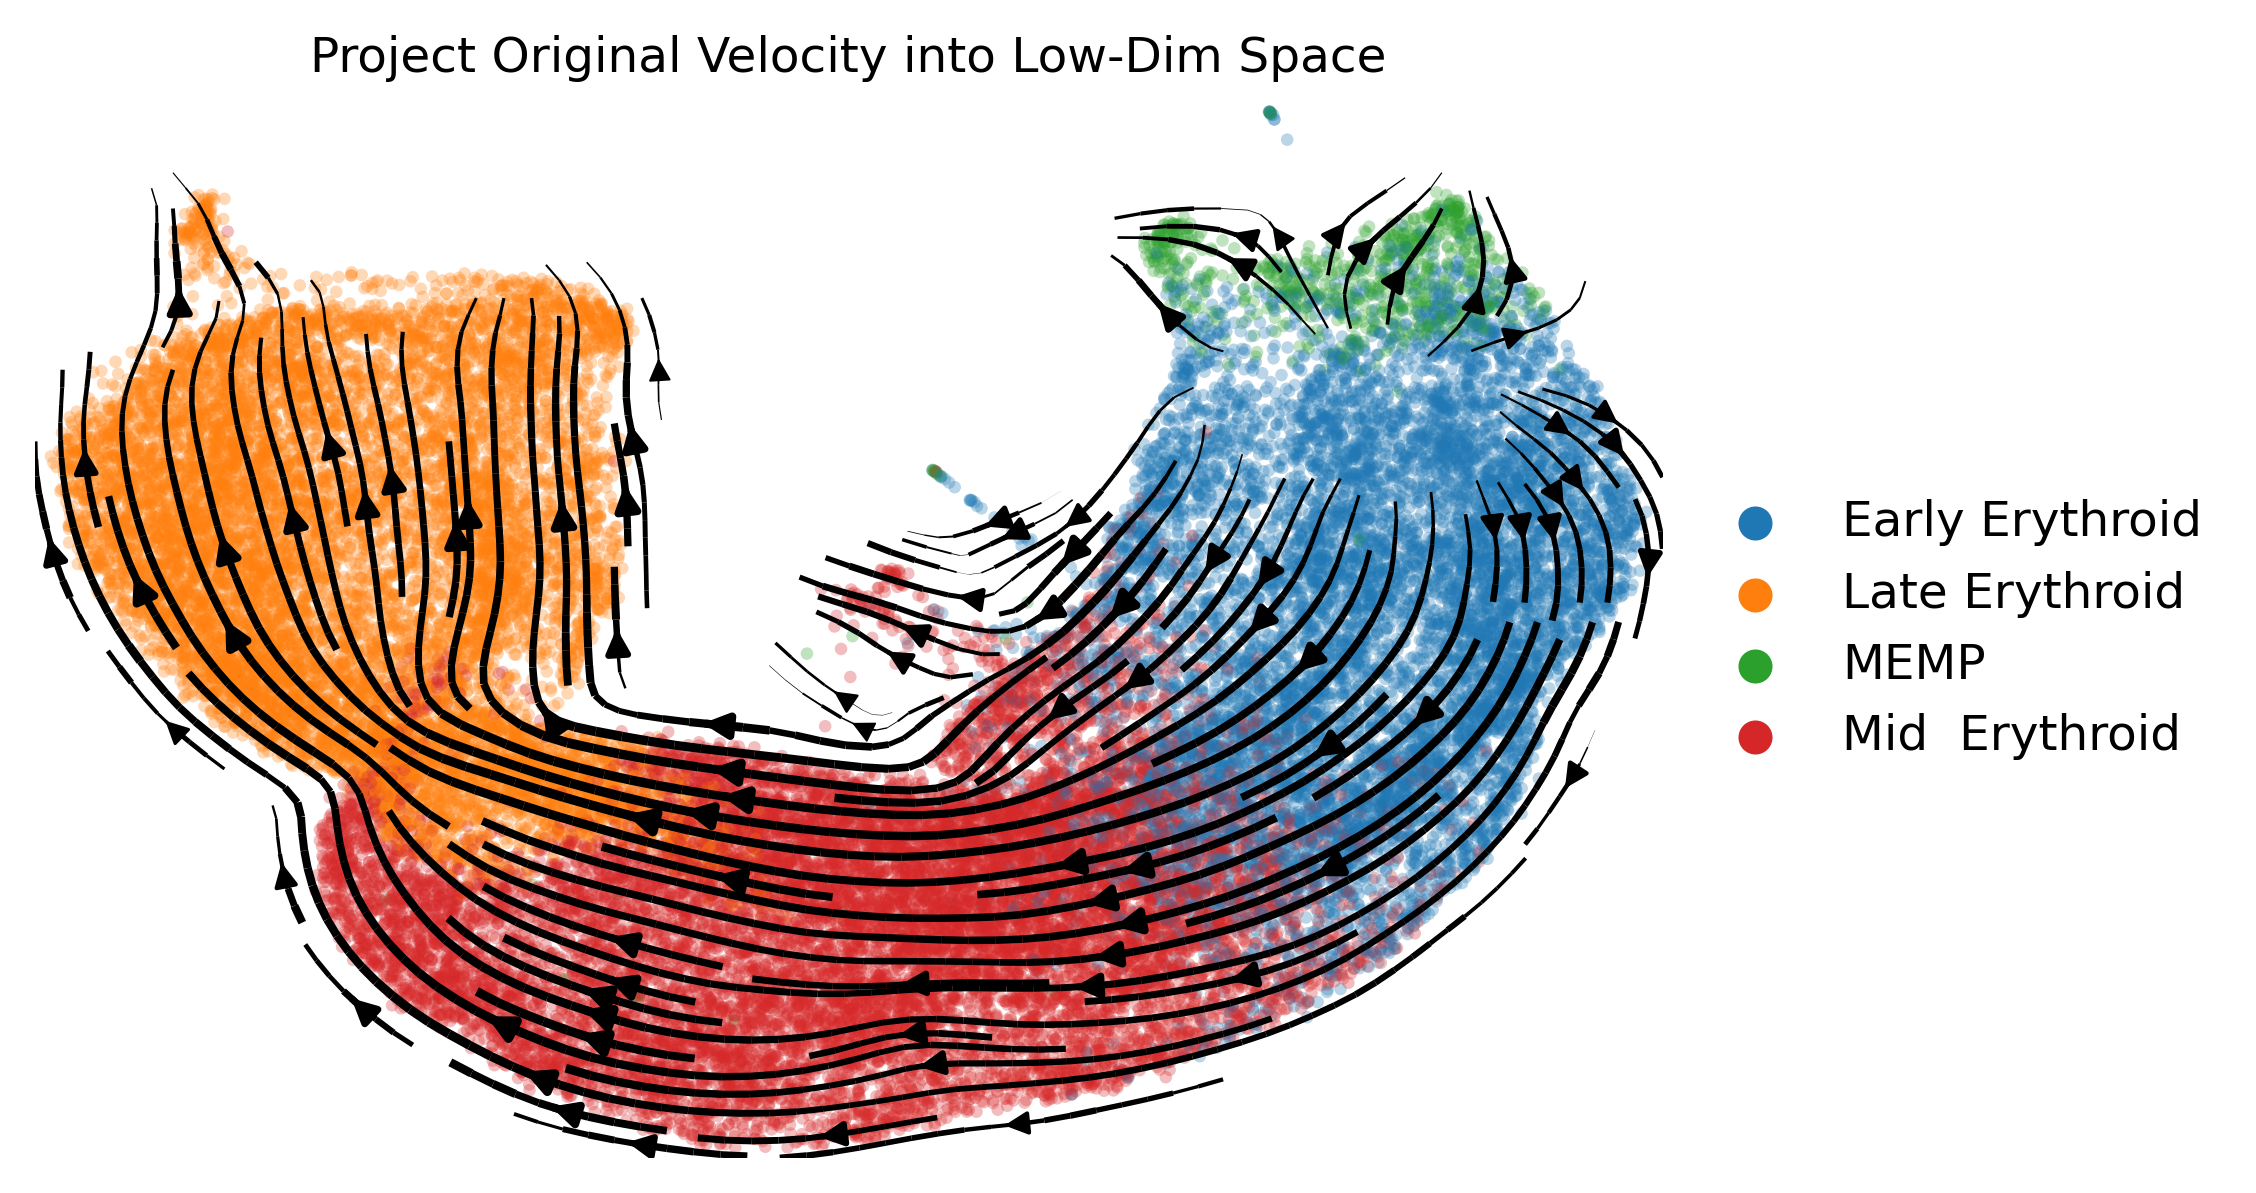

# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.7205372, ('Mid  Erythroid', 'Late Erythroid'): 0.7241146}
Total Mean: 0.7223259210586548
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.99989825, ('Mid  Erythroid', 'Late Erythroid'): 0.9997855}
Total Mean: 0.9998418688774109
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.6032172282413552, ('Mid  Erythroid', 'Late Erythroid'): 0.7000645642255191}
Total Mean: 0.6516408962334371
# In-cluster Coherence
{'Early Erythroid': 0.9998989, 'Late Erythroid': 0.9998619, 'MEMP': 0.9998241, 'Mid  Erythroid': 0.9998785}
Total Mean: 0.9998658895492554
# In-cluster Confidence
{'Early Erythroid': 0.9998918638761054, 'Late Erythroid': 0.9998528445920637, 'MEMP': 0.9997983747308359, 'Mid  Erythroid': 0.9998702206150619}
Total Mean: 0.9998533259535167


In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='Melania_Erythroid_human_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity", x_emb=args.vis_key)
    
    
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.87 0.13]


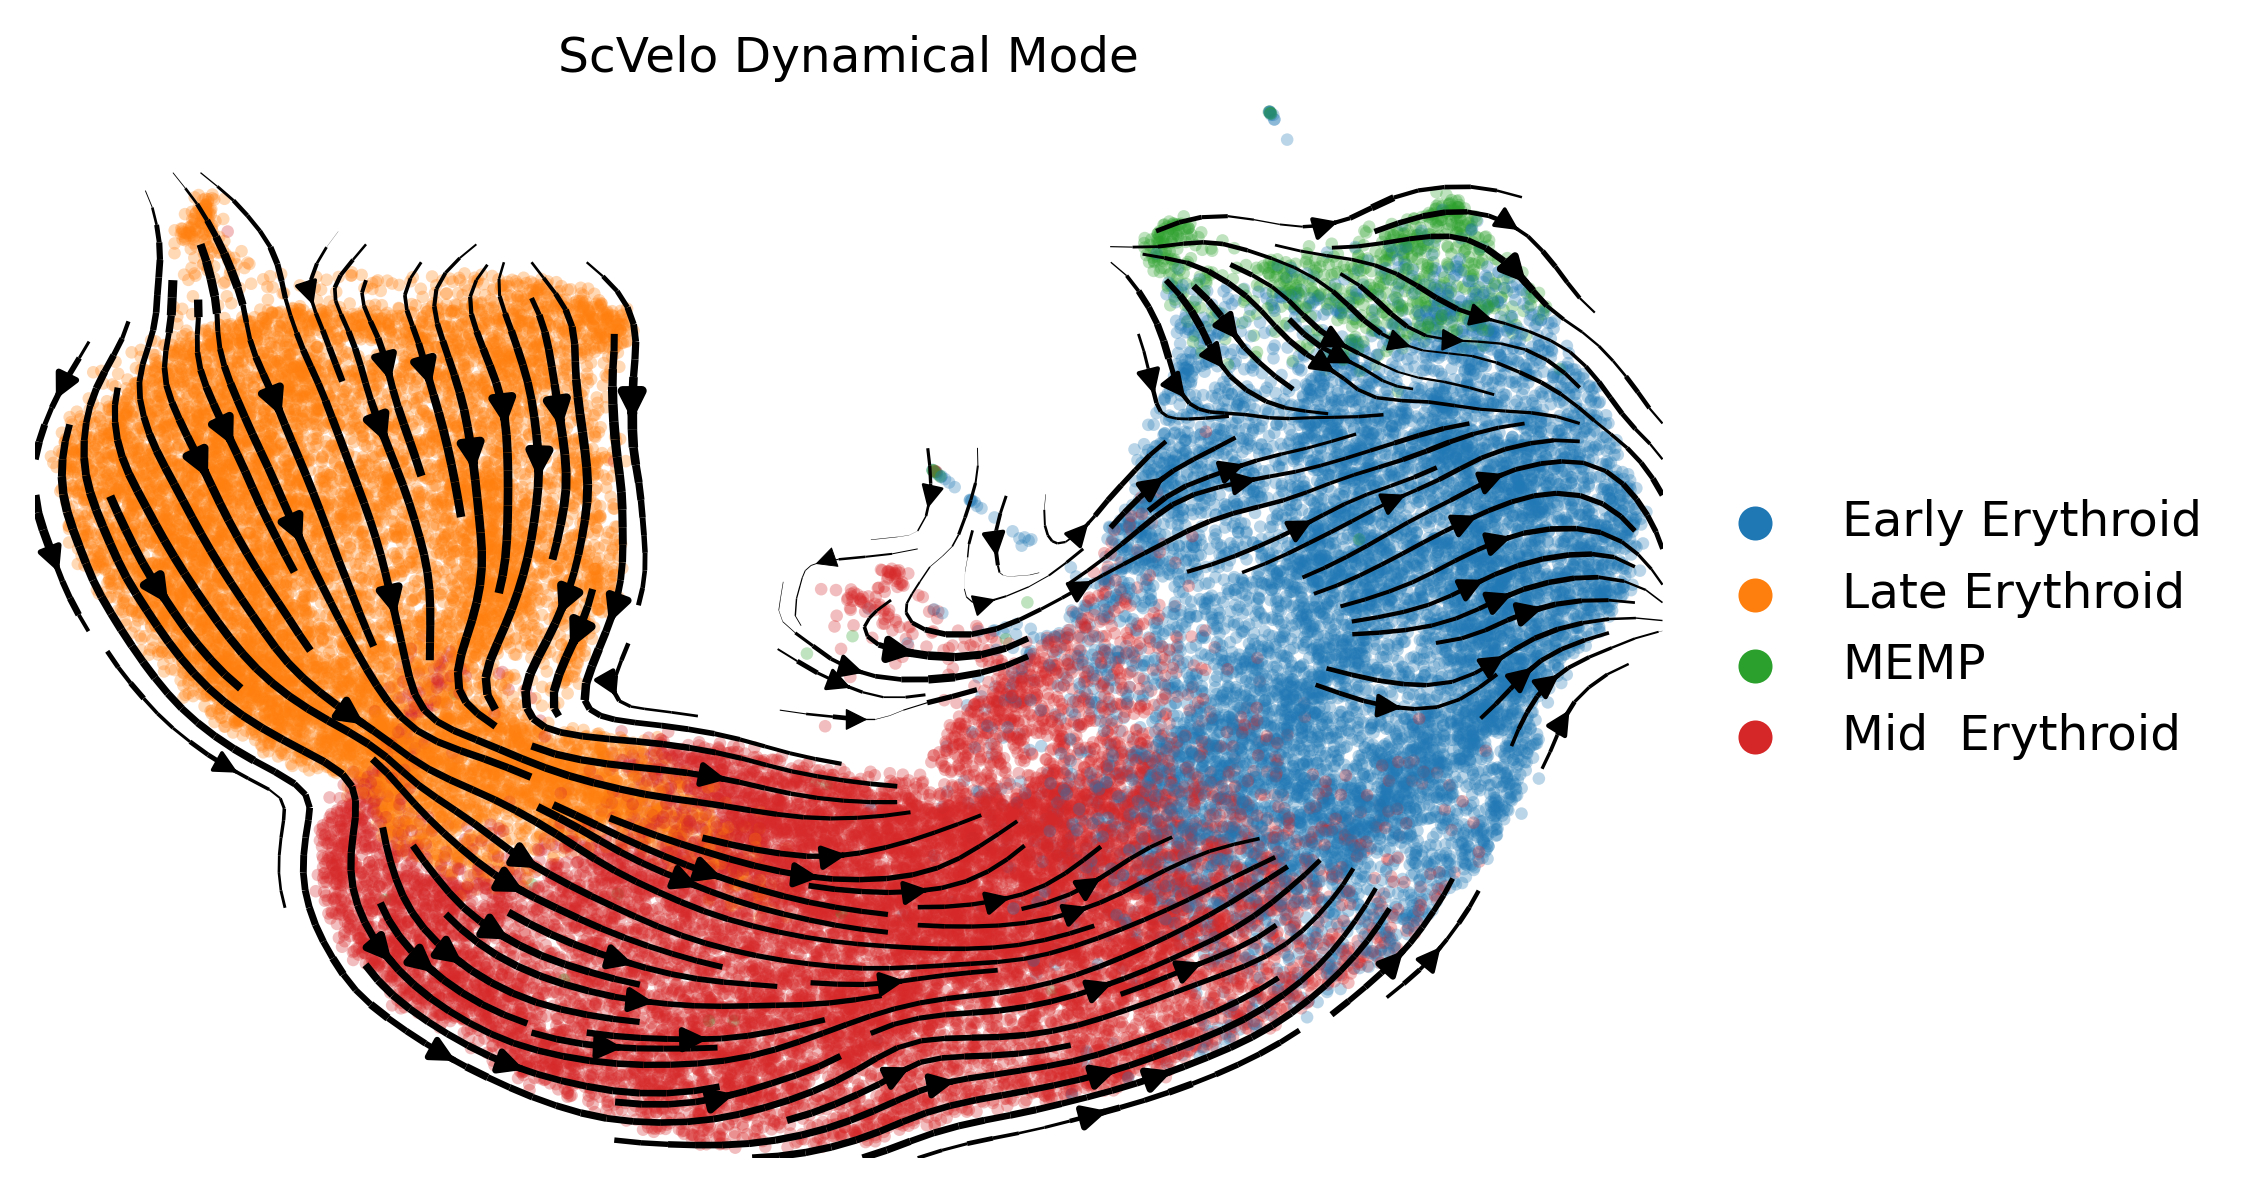

# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.14369497, ('Mid  Erythroid', 'Late Erythroid'): 0.06293816}
Total Mean: 0.10331656038761139
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.8902306947472891, ('Mid  Erythroid', 'Late Erythroid'): 0.9080215984089324}
Total Mean: 0.8991261465781107
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.2430820316268593, ('Mid  Erythroid', 'Late Erythroid'): -0.7077535053426887}
Total Mean: -0.47541776848477396
# In-cluster Coherence
{'Early Erythroid': 0.9049074038700071, 'Late Erythroid': 0.9450015070459747, 'MEMP': 0.9215272839618723, 'Mid  Erythroid': 0.911610936926438}
Total Mean: 0.920761782951073
# In-cluster Confidence
{'Early Erythroid': 0.900162856064134, 'Late Erythroid': 0.9404908583707711, 'MEMP': 0.912195178842626, 'Mid  Erythroid': 0.9061296017960555}
Total Mean: 0.9147446237683967


In [10]:
adata = scanpy.read_h5ad(os.path.join(par_path, fast_data_path))
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=350, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [11]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)